In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import scipy.io.wavfile as wav
from scipy.fftpack import dct
import wave
from pylab import *
import seaborn as sns

In [2]:
sample_rate, signal = wav.read('sounds/osr.wav')  # File assumed to be in the same directory
signal = signal[0:int(3.5 * sample_rate)]
signal

array([ -919, -1314, -1049, ...,   148,   136,   120], dtype=int16)

In [3]:
def show_wave_n_spec(speech, amt=1.0):
    spf = wave.open(speech,'r')
    sound_info = spf.readframes(-1)
    sound_info = fromstring(sound_info, 'Int16')

    f = spf.getframerate()
    sound_info = sound_info[:int(len(sound_info)*amt)]
    
    subplot(211)
    plot(sound_info)
    title('Wave from and spectrogram of %s' % sys.argv[1])

    subplot(212)
    spectrogram = specgram(sound_info, Fs = f, scale_by_freq=True,sides='default')
    
    show()
    spf.close()
    return sound_info, spectrogram, f



/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


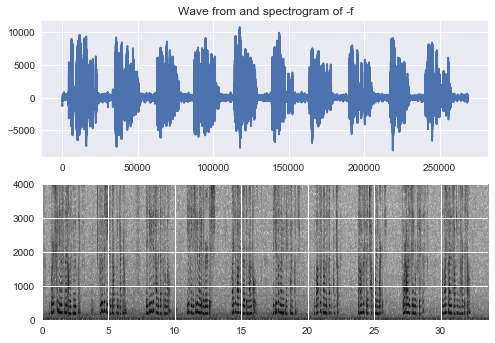

In [4]:
fil = 'sounds/osr.wav'
pre_emphasis = .97
waveform, spectrogram, sample_rate = show_wave_n_spec(fil, 1)
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])


In [5]:
frame_size = .025
frame_stride = .01

In [6]:
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

In [7]:
frames

array([[-9.1900e+02, -4.2257e+02,  2.2558e+02, ...,  4.9530e+01,
         1.0324e+02,  4.9510e+01],
       [-4.6220e+01,  1.8820e+01, -3.6160e+01, ...,  4.1050e+01,
        -2.4020e+01, -1.9070e+01],
       [ 1.5450e+01, -2.7830e+01, -2.3430e+01, ..., -2.4500e+00,
         8.7220e+01,  7.6590e+01],
       ...,
       [-2.4600e+00,  3.3450e+01,  2.5440e+01, ...,  2.8500e+00,
        -4.6700e+01, -3.5750e+01],
       [-2.4380e+01, -1.0340e+01, -2.8850e+01, ...,  4.9300e+01,
         1.8590e+01,  2.8920e+01],
       [-1.7540e+01, -5.0500e+00,  4.8300e+00, ...,  4.8000e-01,
         2.5120e+01, -1.3490e+01]])

In [8]:
frames *= np.hamming(frame_length)


In [9]:
NFFT = 512

mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
pow_frames = (1.0/NFFT)*pow(mag_frames, 2)
pow_frames.shape

(348, 257)

In [10]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)


In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

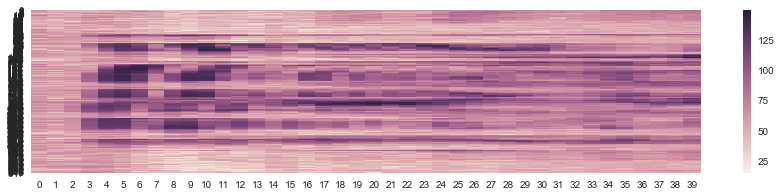

In [12]:
# sns.heatmap(filter_banks)
sns.heatmap(filter_banks)
show()

In [16]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)


(348, 12)


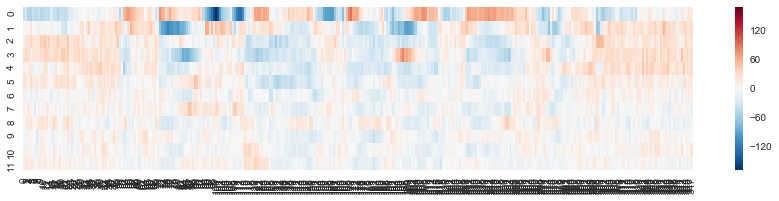

In [17]:
print(mfcc.shape)
sns.heatmap(mfcc.T)
show()